### Задание

1) Модифицируйте код и реализуйте [Wasserstein GAN](https://arxiv.org/abs/1701.07875) ([From GAN to WGAN
](https://lilianweng.github.io/posts/2017-08-20-gan/)) используя weight clipping. (1 балл)

2) Замените  weight clipping на [gradient penalty](https://arxiv.org/pdf/1704.00028v3.pdf). (1 балл)

3) Добавьте к обучению WGAN условие на метку, продемонстрируйте [условную генерацию](https://arxiv.org/pdf/1411.1784.pdf).  (1 балл) 

Напишите отчет о том, что попробовали, какие результаты получили, какую архитектуру использовали, как вам кажется надо обучать GAN, чтобы добиться сходимости? Каждый пункт обязательно сопроводите визуализациями.

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset

import torchvision
import matplotlib.pyplot as plt
import numpy as np

from torch.autograd import Variable

from IPython.display import clear_output

In [2]:
class Config:
    pass

config = Config()
config.mnist_path = None
config.batch_size = 32
config.num_workers = 3
config.num_epochs = 20
config.noise_size = 50
config.print_freq = 100


In [3]:
train = torchvision.datasets.FashionMNIST("fashion_mnist", train=True, transform=torchvision.transforms.ToTensor(), download=True)

100%|██████████| 26421880/26421880 [00:02<00:00, 11561540.11it/s]


Extracting fashion_mnist/FashionMNIST/raw/train-images-idx3-ubyte.gz to fashion_mnist/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 200423.01it/s]


Extracting fashion_mnist/FashionMNIST/raw/train-labels-idx1-ubyte.gz to fashion_mnist/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:01<00:00, 3949940.35it/s]


Extracting fashion_mnist/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to fashion_mnist/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 5812187.62it/s]

Extracting fashion_mnist/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to fashion_mnist/FashionMNIST/raw



In [4]:
dataloader = DataLoader(train, batch_size=config.batch_size, shuffle=True)

In [5]:
len(dataloader)

1875

In [6]:
for image, cat in dataloader:
    break

In [7]:
image.size()

torch.Size([32, 1, 28, 28])

In [8]:
28*28

784

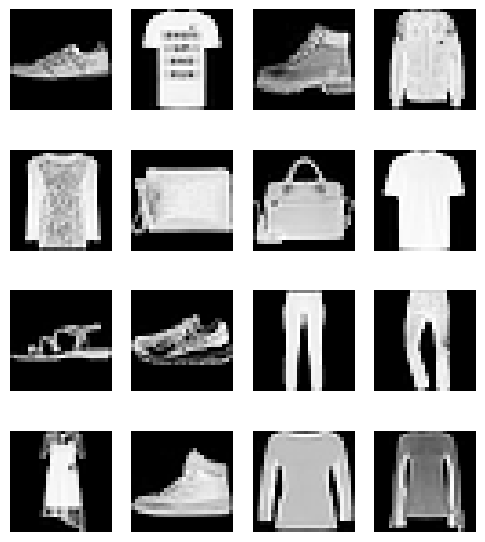

In [10]:
batch = next(iter(dataloader))
plt.figure(figsize=(6, 7))
for i in range(16):
    plt.subplot(4, 4, i + 1)
    plt.imshow(batch[0][i].squeeze(0), cmap=plt.cm.Greys_r)
    plt.axis('off')
    

### Vanilla GAN

In [ ]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.model = nn.Sequential( 
            nn.Linear(config.noise_size, 200),
            nn.ReLU(inplace=True),
            nn.Linear(200, 28*28),
            nn.Sigmoid())
        
    def forward(self, x):
        return self.model(x)
    
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(28*28, 200),
            nn.ReLU(inplace=True),
            nn.Linear(200, 50),
            nn.ReLU(inplace=True),
            nn.Linear(50, 1), 
            nn.Sigmoid())
    def forward(self, x):
        return self.model(x)

In [ ]:
generator = Generator()
discriminator = Discriminator()

In [ ]:
optim_G = optim.Adam(params=generator.parameters(), lr=0.0001)
optim_D = optim.Adam(params=discriminator.parameters(), lr=0.0001)

criterion = nn.BCELoss()

In [ ]:
input = Variable(torch.FloatTensor(config.batch_size, 28*28))
noise = Variable(torch.FloatTensor(config.batch_size, config.noise_size))
fixed_noise = Variable(torch.FloatTensor(config.batch_size, config.noise_size).normal_(0, 1))
label = Variable(torch.FloatTensor(config.batch_size))
real_label = 1
fake_label = 0

Epoch:20 Iter: 1800 errD_x: 0.54 errD_z: 0.20 errG: 1.95


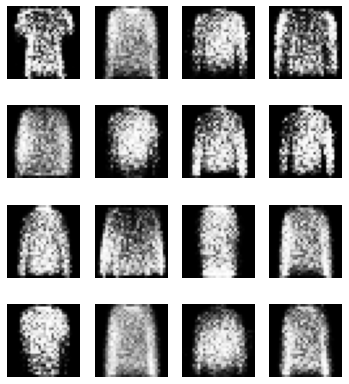

In [ ]:
from tqdm.notebook import tqdm

ERRD_x = np.zeros(config.num_epochs)
ERRD_z = np.zeros(config.num_epochs)
ERRG = np.zeros(config.num_epochs)
N = len(dataloader)

for epoch in range(config.num_epochs):
    for iteration, (images, cat) in enumerate(tqdm(dataloader)):
        ####### 
        # Discriminator stage: maximize log(D(x)) + log(1 - D(G(z))) 
        #######
        discriminator.zero_grad()
        
        # real
        label.data.fill_(real_label)
        input_data = images.view(images.shape[0], -1)
        output = discriminator(input_data)
        errD_x = criterion(output.squeeze(1), label)
        ERRD_x[epoch] += errD_x.item()
        errD_x.backward()
        
        # fake 
        noise.data.normal_(0, 1)
        fake = generator(noise)
        label.data.fill_(fake_label)
        output = discriminator(fake.detach())
        errD_z = criterion(output.squeeze(1), label)
        ERRD_z[epoch] += errD_z.item()
        errD_z.backward()
        
        optim_D.step()
        
        ####### 
        # Generator stage: maximize log(D(G(x))
        #######
        generator.zero_grad()
        label.data.fill_(real_label)
        output = discriminator(fake)
        errG = criterion(output.squeeze(1), label)
        ERRG[epoch] += errG.item()
        errG.backward()
        
        optim_G.step()
        
        if (iteration+1) % config.print_freq == 0:
            fake = generator(fixed_noise)
            plt.figure(figsize=(6, 7))
            for i in range(16):
                plt.subplot(4, 4, i + 1)
                plt.imshow(fake[i].detach().numpy().reshape(28, 28), cmap=plt.cm.Greys_r)
                plt.axis('off')
            clear_output(True)
            print('Epoch:{} Iter: {} errD_x: {:.2f} errD_z: {:.2f} errG: {:.2f}'.format(epoch+1,
                                                                                            iteration+1, 
                                                                                            errD_x.item(),
                                                                                            errD_z.item(), 
                                                                                            errG.item()))
            plt.show()

Как раз столкнулись с типичной проблемой ганов: mode collapse. В основном генерируются вещи с длинными рукавами

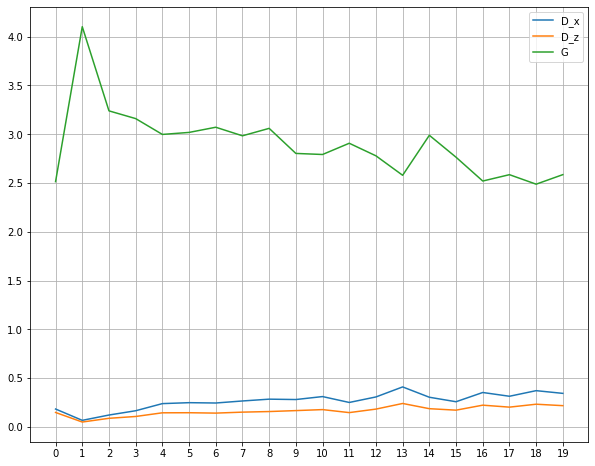

In [ ]:
ERRD_x = np.array(ERRD_x) / len(dataloader)
ERRD_z = np.array(ERRD_z) / len(dataloader)
ERRG = np.array(ERRG) / len(dataloader)

plt.figure(figsize=(10, 8))
plt.grid()
plt.xticks(np.arange(len(ERRD_x)))
plt.plot(np.arange(len(ERRD_x)), ERRD_x, label='D_x')
plt.plot(np.arange(len(ERRD_z)), ERRD_z, label='D_z')
plt.plot(np.arange(len(ERRG)), ERRG, label='G')
plt.legend();

In [ ]:
torch.save(discriminator.state_dict(), "vanillaGAN_d.pth")
torch.save(generator.state_dict(), "vanillaGAN_g.pth")

### WGAN with weight clipping

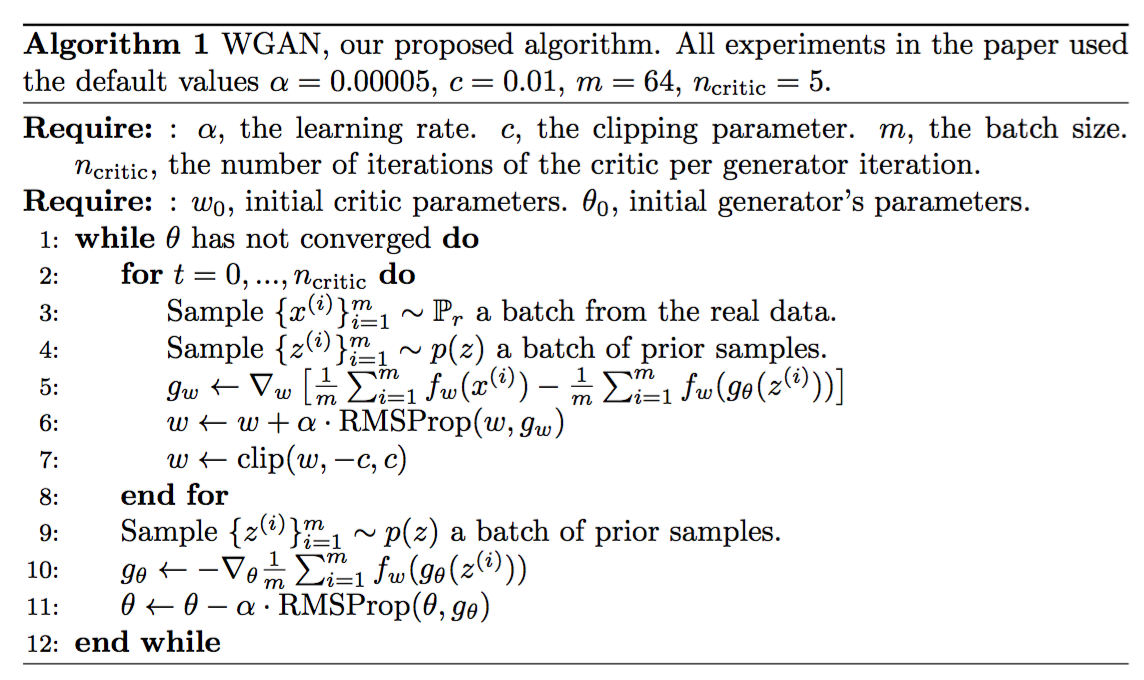

In [ ]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.model = nn.Sequential( 
            nn.Linear(config.noise_size, 200),
            nn.ReLU(inplace=True),
            nn.Linear(200, 28*28),
            nn.Sigmoid())
        
    def forward(self, x):
        return self.model(x)
    
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(28*28, 200),
            nn.ReLU(inplace=True),
            nn.Linear(200, 50),
            nn.ReLU(inplace=True),
            nn.Linear(50, 1))
    def forward(self, x):
        return self.model(x)

In [ ]:
generator = Generator()
discriminator = Discriminator()

optim_G = optim.RMSprop(params=generator.parameters(), lr=0.00005)
optim_D = optim.RMSprop(params=discriminator.parameters(), lr=0.00005)

fixed_noise = Variable(torch.FloatTensor(config.batch_size, config.noise_size).normal_(0, 1))
noise = Variable(torch.FloatTensor(config.batch_size, config.noise_size))

Epoch:20 Iter: 1800 errD: -0.01 errG: -0.03


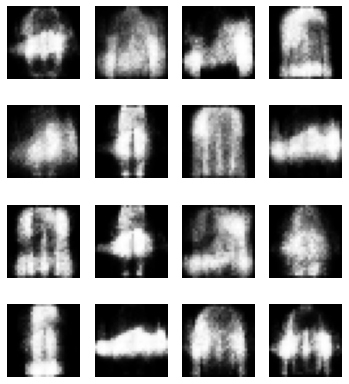

In [ ]:
c = 0.01
n_critic = 5

ERRD = np.zeros(config.num_epochs)
ERRG = np.zeros(config.num_epochs)
N = len(dataloader)

for epoch in range(config.num_epochs):
    for iteration, (images, cat) in enumerate(dataloader):
        discriminator.zero_grad()
        # real
        input_data = images.view(images.shape[0], -1)
        output_real = discriminator(input_data)
        
        # fake 
        noise.data.normal_(0, 1)
        fake = generator(noise)
        output_fake = discriminator(fake.detach())
        
        # Wasserstein dist
        errD = -(output_real.mean() - output_fake.mean())
        ERRD[epoch] += errD.item()
        errD.backward()
        optim_D.step()
        
        for param in discriminator.parameters():
            param.data.clamp_(-c, c)
        
        ####### 
        # Generator 
        #######
        if (iteration + 1) % n_critic == 0:
            generator.zero_grad()
            output = discriminator(fake)
            errG = -output.mean()
            ERRG[epoch] += errG.item()
            errG.backward()
            optim_G.step()
          
        if (iteration+1) % config.print_freq == 0:
            fake = generator(fixed_noise)
            plt.figure(figsize=(6, 7))
            for i in range(16):
                plt.subplot(4, 4, i + 1)
                plt.imshow(fake[i].detach().numpy().reshape(28, 28), cmap=plt.cm.Greys_r)
                plt.axis('off')
            clear_output(True)
            print('Epoch:{} Iter: {} errD: {:.2f} errG: {:.2f}'.format(epoch+1,iteration+1,
                                                                       errD.item(), errG.item()))
            plt.show()
            
ERRD = np.array(ERRD) / N
ERRG = np.array(ERRG) / N

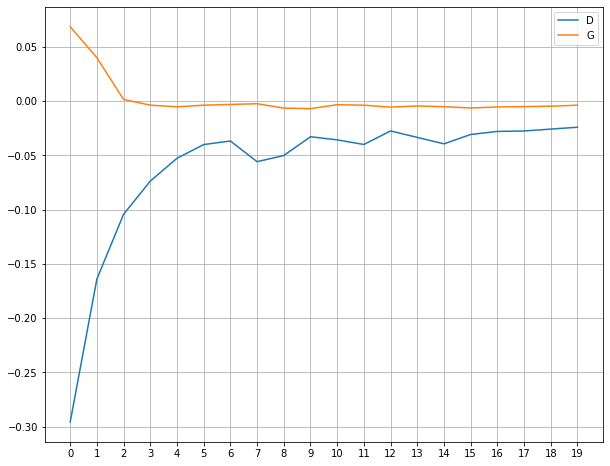

In [ ]:
plt.figure(figsize=(10, 8))
plt.grid()
plt.xticks(np.arange(len(ERRD)))
plt.plot(np.arange(len(ERRD)), ERRD, label='D')
plt.plot(np.arange(len(ERRG)), ERRG, label='G')
plt.legend();

In [ ]:
torch.save(discriminator.state_dict(), "WGAN_d.pth")
torch.save(generator.state_dict(), "WGAN_g.pth")

### WGAN-GP

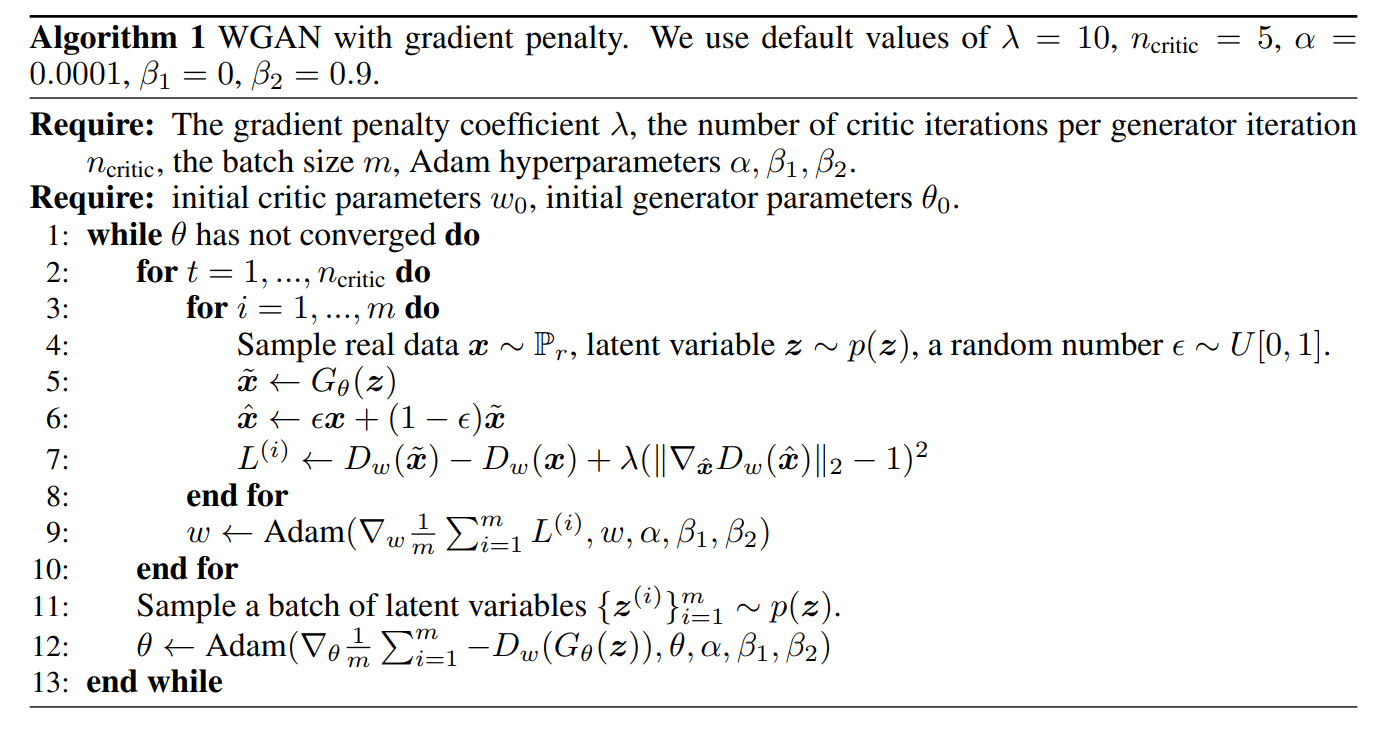

In [ ]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.model = nn.Sequential( 
            nn.Linear(config.noise_size, 200),
            nn.ReLU(inplace=True),
            nn.Linear(200, 28*28),
            nn.Sigmoid())
        
    def forward(self, x):
        return self.model(x)
    
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(28*28, 200),
            nn.ReLU(inplace=True),
            nn.Linear(200, 50),
            nn.ReLU(inplace=True),
            nn.Linear(50, 1))
    def forward(self, x):
        return self.model(x)

In [ ]:
generator = Generator()
discriminator = Discriminator()

beta_1 = 0
beta_2 = 0.9
lr = 0.0001
optim_G = optim.Adam(params=generator.parameters(), lr=lr, betas=(beta_1, beta_2))
optim_D = optim.Adam(params=discriminator.parameters(), lr=lr, betas=(beta_1, beta_2))

fixed_noise = Variable(torch.FloatTensor(config.batch_size, config.noise_size).normal_(0, 1))
noise = Variable(torch.FloatTensor(config.batch_size, config.noise_size))

In [ ]:
def gradient_of_discriminator_score(discriminator, real, fake, epsilon):
    interpolated_images = real * epsilon + fake * (1 - epsilon)
    mixed_scores = discriminator(interpolated_images)

    gradient = torch.autograd.grad(
        inputs=interpolated_images,
        outputs=mixed_scores,
        grad_outputs=torch.ones_like(mixed_scores),
        create_graph=True,
        retain_graph=True,
    )[0]
    
    return gradient

def gradient_penalty_l2_norm(gradient):
    gradient = gradient.view(len(gradient), -1)
    gradient_norm = gradient.norm(2, dim=1)
    penalty = torch.mean((gradient_norm - 1) ** 2)
    return penalty

Epoch:20 Iter: 1800 errD: -0.40 errG: 0.22


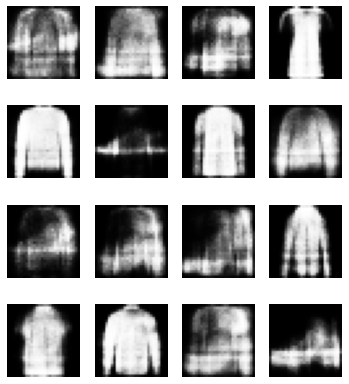

In [ ]:
Lambda = 10
n_critic = 5

ERRD = np.zeros(config.num_epochs)
ERRG = np.zeros(config.num_epochs)
N = len(dataloader)

for epoch in range(config.num_epochs):
    for iteration, (images, cat) in enumerate(dataloader):
        discriminator.zero_grad()
        # real
        input_data = images.view(images.shape[0], -1)
        output_real = discriminator(input_data)
        
        # fake 
        noise.data.normal_(0, 1)
        fake = generator(noise)
        output_fake = discriminator(fake.detach())
        
        # Gradient Penalty
        
        epsilon = torch.rand(len(input_data), 1, 1, 1, requires_grad=True)
        gradient = gradient_of_discriminator_score(discriminator, input_data, fake.detach(), epsilon)
        gp = gradient_penalty_l2_norm(gradient)
        errD = torch.mean(output_fake - output_real + Lambda * gp)
        ERRD[epoch] += errD.item()
        errD.backward()
        optim_D.step()
        
        ####### 
        # Generator 
        #######
        if (iteration + 1) % n_critic == 0:
            generator.zero_grad()
            output = discriminator(fake)
            errG = -output.mean()
            ERRG[epoch] += errG.item()
            errG.backward()
            optim_G.step()
          
        if (iteration+1) % config.print_freq == 0:
            fake = generator(fixed_noise)
            plt.figure(figsize=(6, 7))
            for i in range(16):
                plt.subplot(4, 4, i + 1)
                plt.imshow(fake[i].detach().numpy().reshape(28, 28), cmap=plt.cm.Greys_r)
                plt.axis('off')
            clear_output(True)
            print('Epoch:{} Iter: {} errD: {:.2f} errG: {:.2f}'.format(epoch+1,iteration+1,
                                                                       errD.item(), errG.item()))
            plt.show()
            
ERRD = np.array(ERRD) / N
ERRG = np.array(ERRG) / N * n_critic

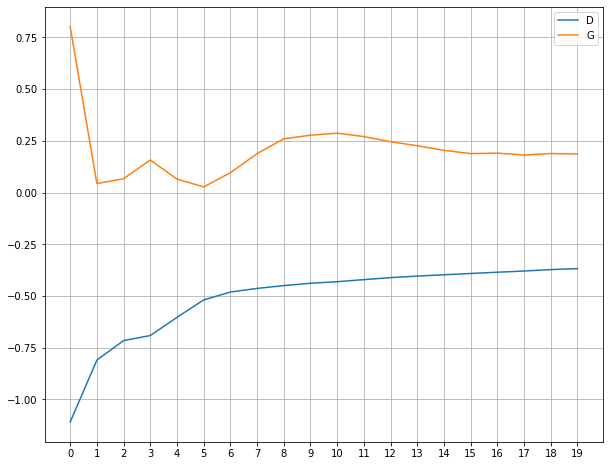

In [ ]:
plt.figure(figsize=(10, 8))
plt.grid()
plt.xticks(np.arange(len(ERRD)))
plt.plot(np.arange(len(ERRD)), ERRD, label='D')
plt.plot(np.arange(len(ERRG)), ERRG, label='G')
plt.legend();

In [ ]:
torch.save(discriminator.state_dict(), "WGAN_GP_d.pth")
torch.save(generator.state_dict(), "WGAN_GP_g.pth")

### Conditional WGAN-GP

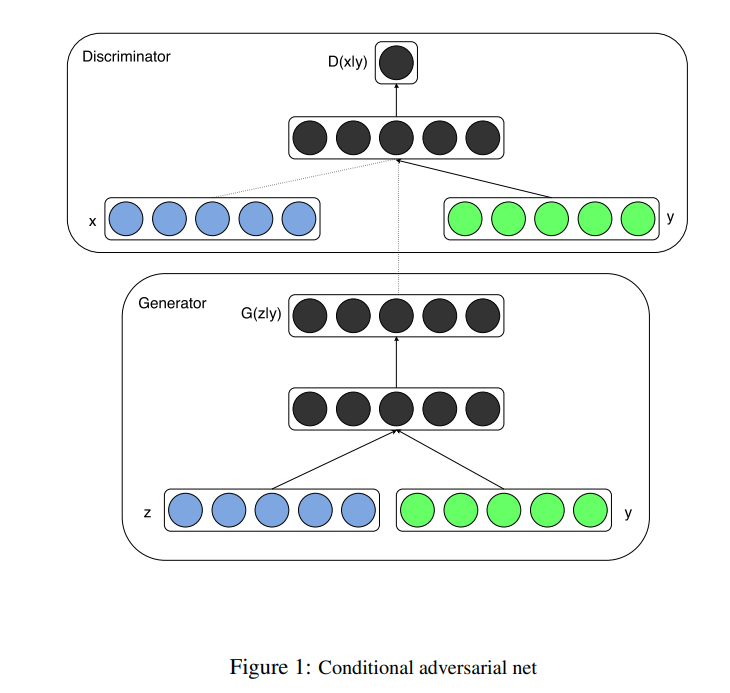

In [21]:
device = 'cuda'

In [24]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        input_dim = config.noise_size + 10
        # auxiliary information
        self.label_embedding = nn.Linear(10, 10)
        self.model = nn.Sequential( 
            nn.Linear(input_dim, 200),
            nn.ReLU(inplace=True),
            nn.Linear(200, 28*28),
            nn.Sigmoid())
        
    def forward(self, x, labels):
        c = self.label_embedding(labels)
        x = torch.cat([x, c], 1)
        return self.model(x)
    
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        input_dim = 28*28 + 10
        self.label_embedding = nn.Linear(10, 10)
        self.model = nn.Sequential(
            nn.Linear(input_dim, 200),
            nn.ReLU(inplace=True),
            nn.Linear(200, 50),
            nn.ReLU(inplace=True),
            nn.Linear(50, 1))
        
    def forward(self, x, labels):
        c = self.label_embedding(labels)
        x = torch.cat([x, c], 1)
        return self.model(x)

In [25]:
generator = Generator().to(device)
discriminator = Discriminator().to(device)

beta_1 = 0
beta_2 = 0.9
lr = 0.0001
optim_G = optim.Adam(params=generator.parameters(), lr=lr, betas=(beta_1, beta_2))
optim_D = optim.Adam(params=discriminator.parameters(), lr=lr, betas=(beta_1, beta_2))

fixed_noise = Variable(torch.FloatTensor(config.batch_size, config.noise_size).normal_(0, 1)).to(device)
noise = Variable(torch.FloatTensor(config.batch_size, config.noise_size)).to(device)

In [26]:
import torch.nn.functional as F

In [27]:
def gradient_of_discriminator_score(discriminator, real, fake, epsilon, fake_labels, real_labels):
    interpolated_images = (real * epsilon + fake * (1 - epsilon)).to(device)
    interpolated_labels = (real_labels * epsilon + fake_labels * (1 - epsilon)).to(device)
    mixed_scores = discriminator(interpolated_images, interpolated_labels)

    gradient = torch.autograd.grad(
        inputs=interpolated_images,
        outputs=mixed_scores,
        grad_outputs=torch.ones_like(mixed_scores),
        create_graph=True,
        retain_graph=True,
    )[0]
    
    return gradient

def gradient_penalty_l2_norm(gradient):
    gradient = gradient.view(len(gradient), -1)
    gradient_norm = gradient.norm(2, dim=1)
    penalty = torch.mean((gradient_norm - 1) ** 2)
    return penalty

Epoch:20 Iter: 1800 errD: -1.58 errG: -6.29


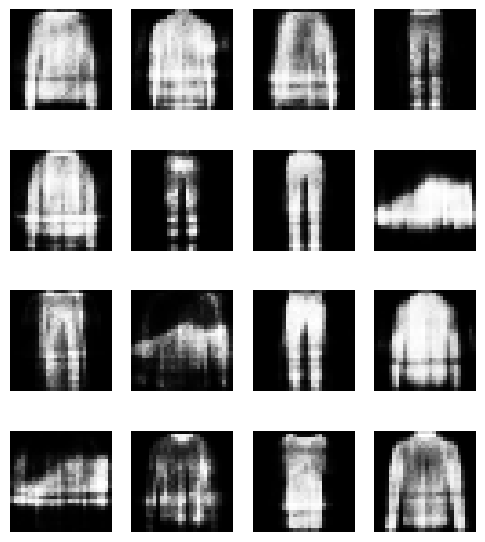

In [28]:
Lambda = 10
n_critic = 5

ERRD = np.zeros(config.num_epochs)
ERRG = np.zeros(config.num_epochs)
N = len(dataloader)

fixed_labels = torch.randint(0, 10, (config.batch_size,))
fixed_labels = F.one_hot(fixed_labels, num_classes=10).float().to(device)

for epoch in range(config.num_epochs):
    for iteration, (images, cat) in enumerate(dataloader):
        discriminator.zero_grad()
        # real
        input_data = images.view(images.shape[0], -1).to(device)
        real_labels = F.one_hot(cat, num_classes=10).float().to(device)
        output_real = discriminator(input_data, real_labels)
        
        # fake 
        noise.data.normal_(0, 1)
        fake_labels = torch.randint(0, 10, (config.batch_size,))
        fake_labels = F.one_hot(fake_labels, num_classes=10).float().to(device)
        fake = generator(noise, fake_labels)
        output_fake = discriminator(fake.detach(), fake_labels)
        
        # Gradient Penalty
        
        epsilon = torch.rand(len(input_data), 1, requires_grad=True).to(device)
        gradient = gradient_of_discriminator_score(discriminator, input_data, fake.detach(), epsilon, fake_labels, real_labels)
        gp = gradient_penalty_l2_norm(gradient)
        errD = torch.mean(output_fake - output_real + Lambda * gp)
        ERRD[epoch] += errD.item()
        errD.backward()
        optim_D.step()
        
        ####### 
        # Generator 
        #######
        if (iteration + 1) % n_critic == 0:
            generator.zero_grad()
            output = discriminator(fake, fake_labels)
            errG = -output.mean()
            ERRG[epoch] += errG.item()
            errG.backward()
            optim_G.step()
        
        with torch.no_grad():
            if (iteration+1) % config.print_freq == 0:
                fake = generator(fixed_noise, fixed_labels)
                plt.figure(figsize=(6, 7))
                for i in range(16):
                    plt.subplot(4, 4, i + 1)
                    plt.imshow(fake[i].detach().cpu().numpy().reshape(28, 28), cmap=plt.cm.Greys_r)
                    plt.axis('off')
                clear_output(True)
                print('Epoch:{} Iter: {} errD: {:.2f} errG: {:.2f}'.format(epoch+1,iteration+1,
                                                                          errD.item(), errG.item()))
                plt.show()
            
ERRD = np.array(ERRD) / N
ERRG = np.array(ERRG) / N * n_critic

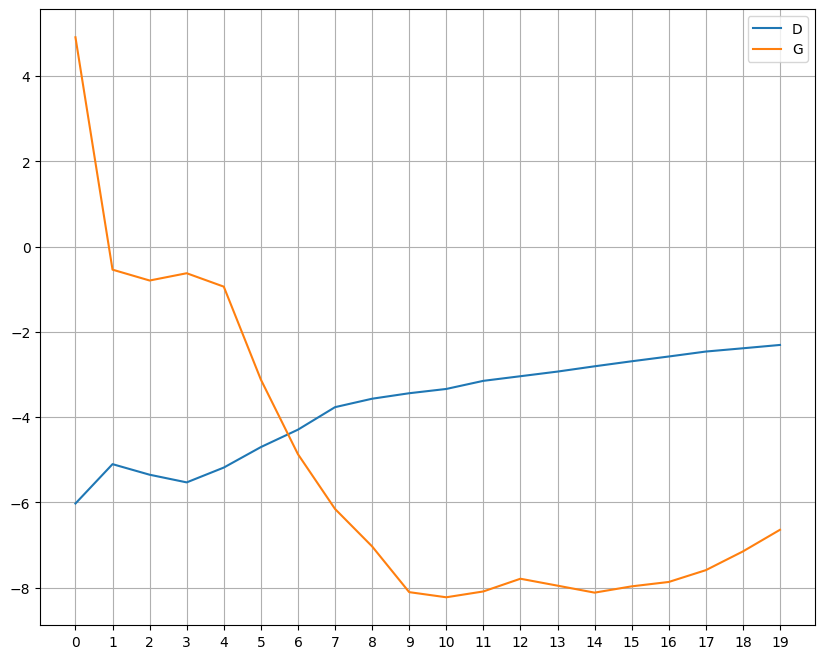

In [29]:
plt.figure(figsize=(10, 8))
plt.grid()
plt.xticks(np.arange(len(ERRD)))
plt.plot(np.arange(len(ERRD)), ERRD, label='D')
plt.plot(np.arange(len(ERRG)), ERRG, label='G')
plt.legend();

In [31]:
torch.save(discriminator.state_dict(), "condition_WGAN_d.pth")
torch.save(generator.state_dict(), "condition_WGAN_g.pth")

пробуемм инферить с меткой 


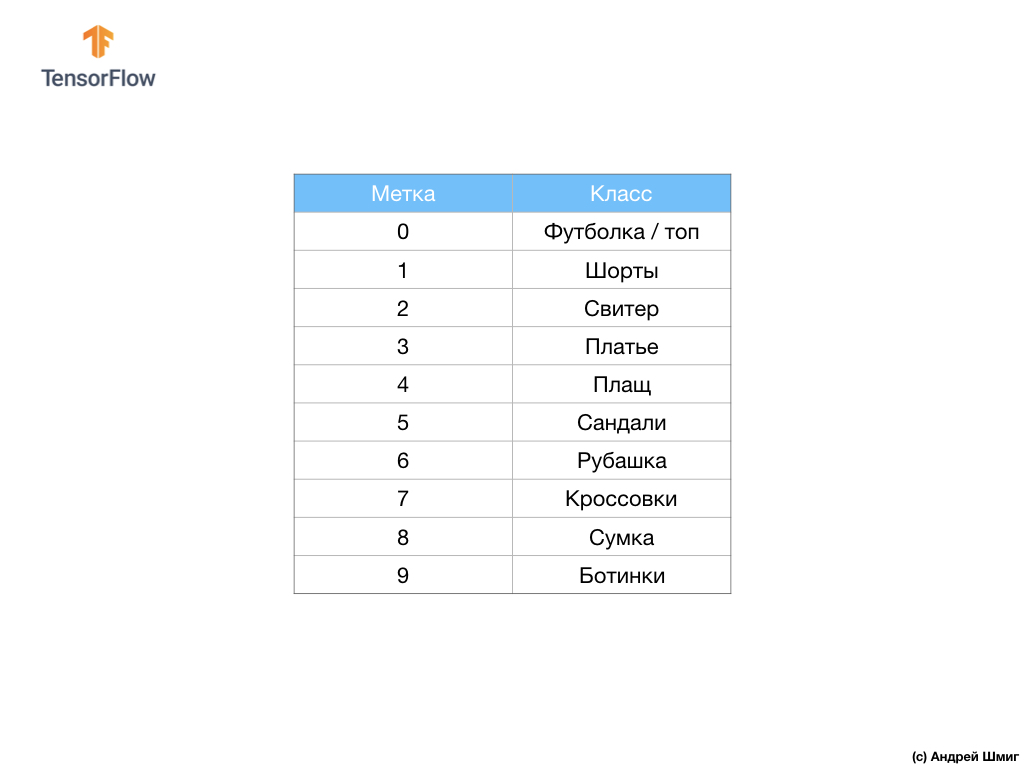

In [32]:
def inference(label):
    noise = torch.FloatTensor(1, config.noise_size).normal_(0, 1).to(device)
    label = F.one_hot(torch.LongTensor([label]), num_classes=10).float().to(device)
    with torch.no_grad():
        generated = generator(noise, label)
        plt.imshow(generated.cpu().numpy().reshape(28, 28), cmap=plt.cm.Greys_r)
        plt.show()

0


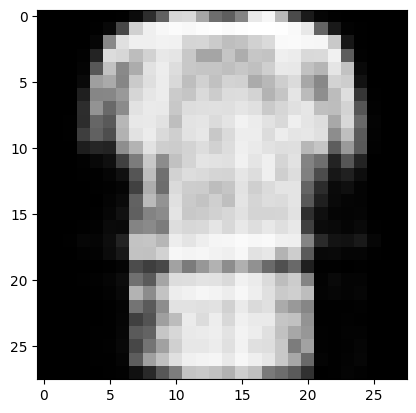

1


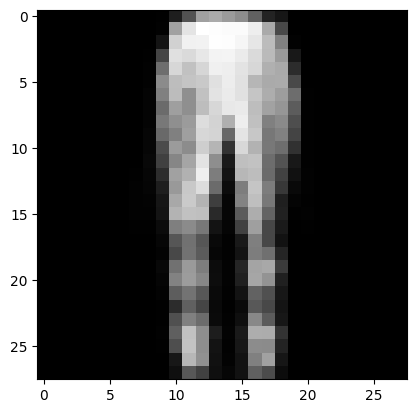

2


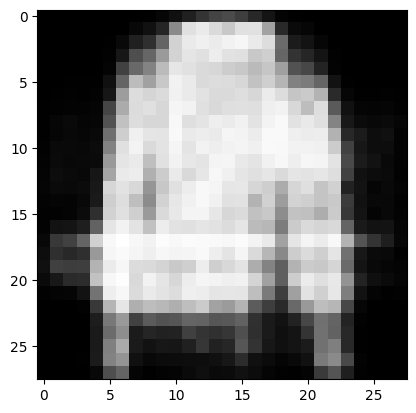

3


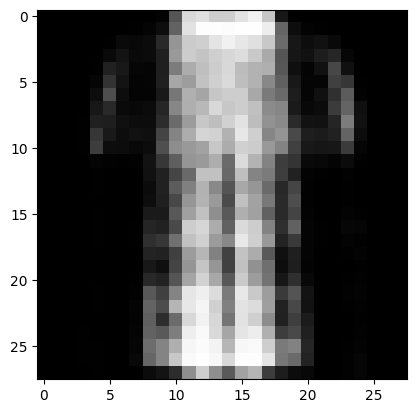

4


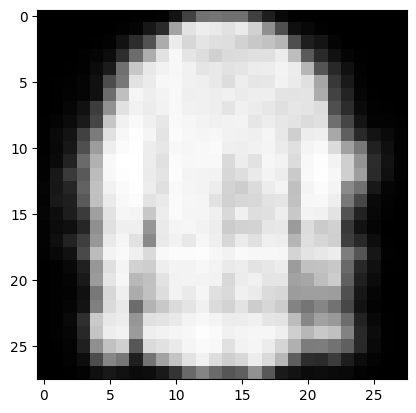

5


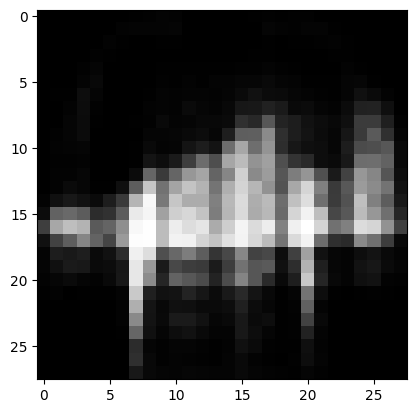

6


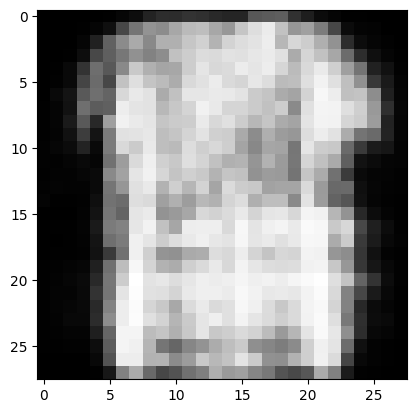

7


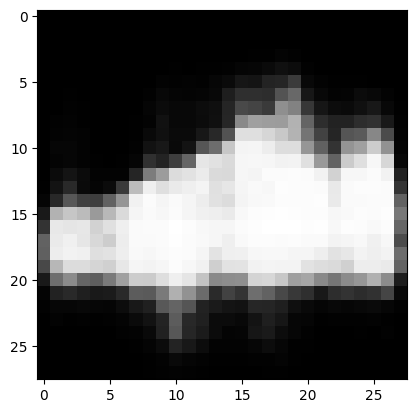

8


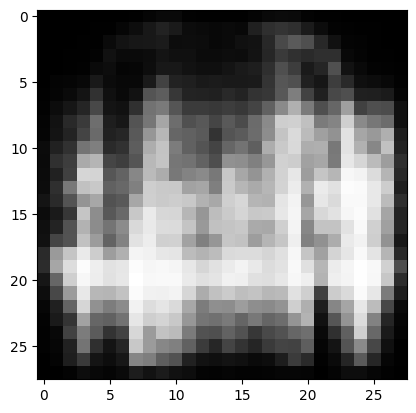

9


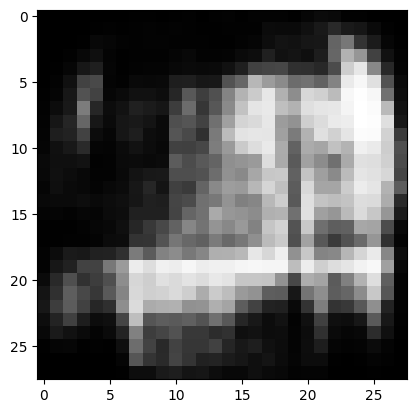

In [33]:
for i in range(10):
  print(i)
  inference(i)

### Выводы

Из предыдущих опытов видно, что wgan-gp работает лучше всего: улучшает сходимость

Хотелось еще попробовать обучить архитектуры более сложные, например, со свертками, но из-за дедлайна уже не получится. Отыграюсь на проекте))